# Lesson 2: Building and Training a CNN for Image Classification

## Introduction

In this notebook, we will build and train a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 and CIFAR-100 datasets. We'll follow the typical data science pipeline:

1. Load and explore the data
2. Analyze the dataset
3. Implement data augmentation
4. Build a CNN model
5. Train and evaluate the model
6. Experiment with different architectures
7. Scale to a more complex dataset (CIFAR-100)

Let's get started!

## 1. Setup and Data Loading

First, let's import the necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
# Check for CUDA (NVIDIA GPU) or MPS (Apple Silicon) availability
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


Now, let's load the CIFAR-10 dataset:

In [3]:
# Define basic transformations for loading the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False, num_workers=2)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Let's visualize some of the images from the dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


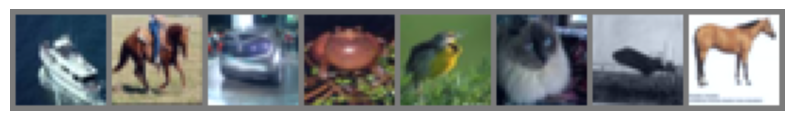

Labels: ship  horse car   frog  bird  cat   plane horse


In [5]:
# Function to show an image
def imshow(img):
    # unnormalize
    img = img * 0.229 + 0.485
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## 2. Data Analysis

Now, let's analyze the dataset to better understand what we're working with.

Number of samples in training set: 50000
Number of samples in test set: 10000
Image dimensions: torch.Size([3, 32, 32])
Samples per class in training set: {6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


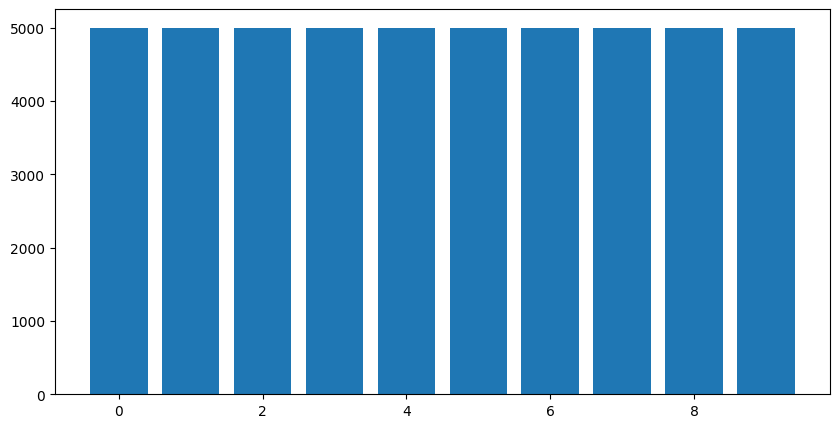

In [ ]:
# TODO: Implement a function to analyze the dataset
# This function should output metrics about the dataset such as:
# - Number of samples in training and test sets
# - Number of samples per class
# - Size of one data sample (image dimensions)

def analyze_dataset(trainset, testset, classes):
    """
    Analyze the dataset and print useful information.
    
    Args:
        trainset: The training dataset
        testset: The test dataset
        classes: List of class names
    """
    # Your code here
    # Hint: You can use trainset.data to access the raw data
    
    # 1. Get the total number of samples
    print(f"Number of samples in training set: {len(trainset)}")
    print(f"Number of samples in test set: {len(testset)}")
    # 2. Get the image dimensions
    print(f"Image dimensions: {trainset[0][0].shape}")
    # 3. Count samples per class in the training set
    class_counts = {}
    for _, label in trainset:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    print(f"Samples per class in training set: {class_counts}")
    
    # 4. Visualize the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())

# Call the function to analyze the dataset
analyze_dataset(trainset, testset, classes)

## 3. Data Augmentation

Data augmentation is a technique to artificially increase the size of the training dataset by applying various transformations to the original images. This helps improve the model's generalization ability.

In [9]:
# TODO: Implement a function for data augmentation
# This function should apply different transformations to the images
# For more information on available transforms, see:
# https://pytorch.org/vision/stable/transforms.html

def get_augmentation_transforms():
    """
    Create a set of data augmentation transforms.
    
    Returns:
        A torchvision.transforms.Compose object with various augmentations
    """
    # Your code here
    # Hint: Use transforms like RandomHorizontalFlip, RandomRotation, ColorJitter, etc.
    
    augmentation_transforms = transforms.Compose([
        # Add your transformations here
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomRotation(degrees=15),

    ])
    
    return augmentation_transforms

# Create a new training dataset with augmentation
augmentation_transforms = get_augmentation_transforms()
augmented_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=augmentation_transforms)
augmented_trainloader = torch.utils.data.DataLoader(augmented_trainset, batch_size=64,
                                                  shuffle=True, num_workers=2)

Let's visualize some of the augmented images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


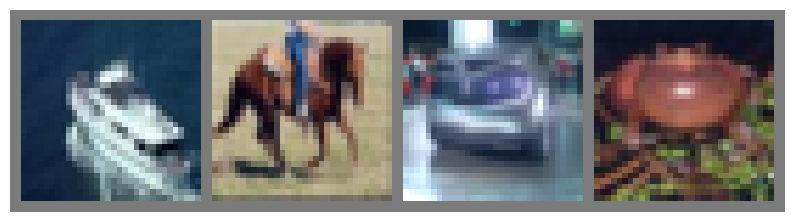

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450979..1.08956].


Original Labels: ship  horse car   frog 


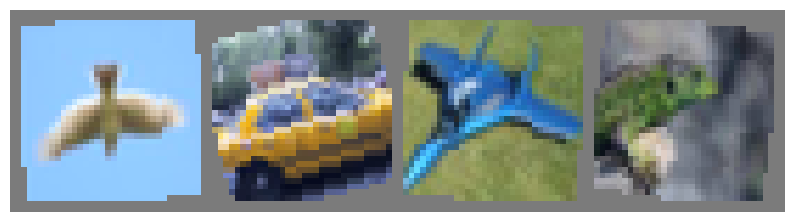

Augmented Labels: bird  car   plane frog 


In [10]:
# Get some random augmented training images
dataiter = iter(augmented_trainloader)
augmented_images, augmented_labels = next(dataiter)

# Show original images
imshow(torchvision.utils.make_grid(images[:4]))
print('Original Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Show augmented images
imshow(torchvision.utils.make_grid(augmented_images[:4]))
print('Augmented Labels:', ' '.join(f'{classes[augmented_labels[j]]:5s}' for j in range(4)))

## 4. Building a Simple CNN

Now, let's build a simple CNN model for image classification.

In [15]:
# Here's a minimal example of a CNN with one convolutional layer and a fully connected layer
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = x.view(-1, 16 * 16)
        x = F.relu(self.fc1(x))
        return x

# Create an instance of the model
model = SimpleCNN(num_classes=10).to(device)
print(model)
# infer one data with the model
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.to(device)
image = images[0]
print(f"Image shape: {image.shape}")
outputs = model(image)
#_, predicted = torch.max(outputs.data, 1)
print(f"Predicted: {outputs.shape}")
print(f"Predicted: {outputs}")


SimpleCNN(
  (conv1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)
Image shape: torch.Size([3, 32, 32])
Predicted: torch.Size([1, 10])
Predicted: tensor([[0.0000, 0.0794, 0.0000, 0.2503, 0.0000, 0.2355, 0.0000, 0.0000, 0.0000,
         0.0802]], device='mps:0', grad_fn=<ReluBackward0>)


## 5. Training the Model

Now, let's implement the training loop for our CNN model.

In [20]:
# TODO: Implement the training loop
# This function should train the model on the training data and evaluate it on the test data
from tqdm import tqdm
# Documentation links:
# - PyTorch optimizers: https://pytorch.org/docs/stable/optim.html
# - PyTorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=5):
    """
    Train the model.
    
    Args:
        model: The neural network model
        trainloader: DataLoader for training data
        testloader: DataLoader for test data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of training epochs
    
    Returns:
        Lists of training losses, training accuracies, and test accuracies
    """
    # Your code here
    # Hint: A typical training loop includes:
    # 1. Iterate through batches of training data
    # 2. Zero the gradients
    # 3. Forward pass
    # 4. Compute loss
    # 5. Backward pass
    # 6. Update weights
    # 7. Evaluate on test data
    
    
    # Initialize lists to track metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        # Your training code here
        bar = tqdm(enumerate(trainloader, 0), total=len(trainloader))
        for i, data in bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Evaluation phase
        
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        # Your evaluation code here
        test_bar = tqdm(enumerate(testloader, 0), total=len(testloader))
        for i, data in test_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        # Print statistics
        train_loss = running_loss / len(trainloader)
        test_loss = test_loss / len(testloader)
        test_acc = 100 * test_correct / test_total
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Acc: {test_acc:.2f}%'
              f'Test Loss: {test_loss:.4f}')
        
    
    return train_losses, train_accuracies, test_accuracies

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
train_losses, train_accuracies, test_accuracies = train_model(
    model, augmented_trainloader, testloader, criterion, optimizer, num_epochs=5)

100%|██████████| 157/157 [00:10<00:00, 15.05it/s] 

Epoch 1/5, Train Loss: 1.9803, Test Acc: 33.31%Test Loss: 1.9402



100%|██████████| 157/157 [00:10<00:00, 15.03it/s] 

Epoch 2/5, Train Loss: 1.8905, Test Acc: 35.41%Test Loss: 1.8208



100%|██████████| 157/157 [00:10<00:00, 15.05it/s] 

Epoch 3/5, Train Loss: 1.8189, Test Acc: 36.49%Test Loss: 1.8067



100%|██████████| 157/157 [00:10<00:00, 15.04it/s] 

Epoch 4/5, Train Loss: 1.7998, Test Acc: 35.34%Test Loss: 1.8072



100%|██████████| 157/157 [00:10<00:00, 15.05it/s] 

Epoch 5/5, Train Loss: 1.8072, Test Acc: 33.28%Test Loss: 1.8257


Let's visualize the training progress:

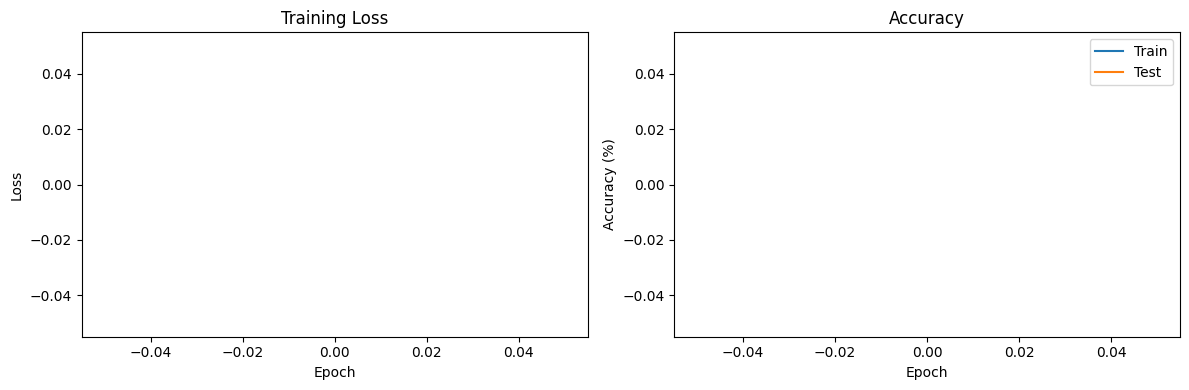

In [21]:
# Plot training and test metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Visualizing Learned Filters

Let's visualize the filters (weights) learned by the convolutional layer:

/var/folders/0x/rrhx54hs64jd2p40qcyw4v880000gp/T/ipykernel_55420/265637176.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar


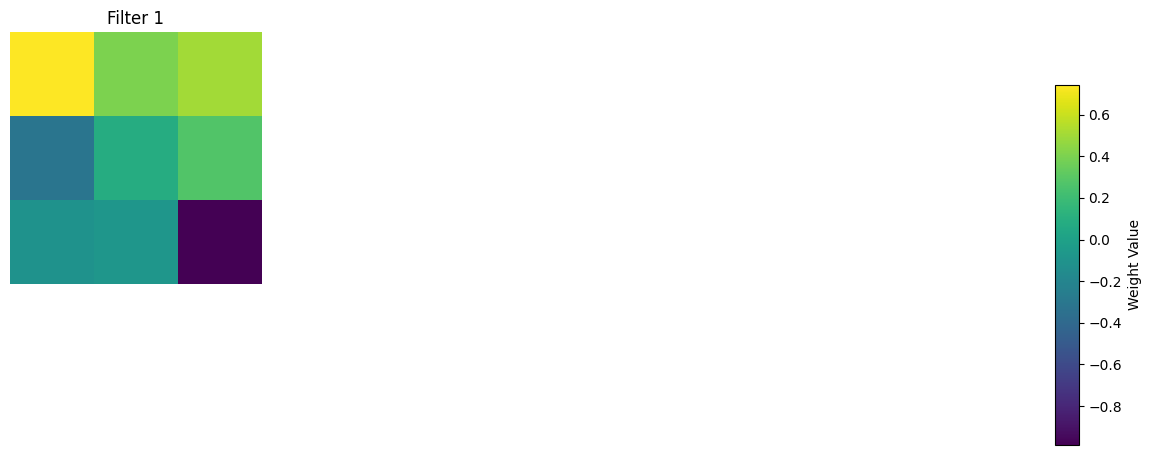

In [22]:
# Get the weights of the first convolutional layer
weights = model.conv1.weight.data.cpu()

# Plot the filters
plt.figure(figsize=(12, 6))
num_filters = weights.shape[0]  # Get actual number of filters

# Create a grid for visualization
rows = 2
cols = 3
for i in range(num_filters):
    if i >= rows * cols:
        break  # Limit the number of filters to display
    
    plt.subplot(rows, cols, i+1)
    
    # For RGB filters, we'll use a single channel representation for simplicity
    # We'll use the average of the 3 channels
    filter_data = weights[i].mean(dim=0).numpy()
    
    # Display the filter
    im = plt.imshow(filter_data, cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')

# Add a colorbar with gradient legend showing actual weight values
cax = plt.axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cmap = plt.cm.viridis
norm = plt.Normalize(weights.min().item(), weights.max().item())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label('Weight Value')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar
plt.show()

## 7. Improving the Model

Now, let's try to improve our model by adding more layers and features.

In [23]:
# TODO: Implement an improved CNN model
# This model should have more convolutional layers and possibly other improvements

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # 3x32x32 -> 16x32x32
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # 16x32x32 -> 16x16x16
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) # 16x16x16 -> 8x16x16
        self.fc1 = nn.Linear(8 * 16 * 16, 128) # 8x16x16 -> 128
        self.fc2 = nn.Linear(128, num_classes) # 128 -> 10
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.view(-1, 8 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the improved model
improved_model = ImprovedCNN(num_classes=10).to(device)
print(improved_model)

# Define loss function and optimizer for the improved model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

# Train the improved model
improved_train_losses, improved_train_accuracies, improved_test_accuracies = train_model(
    improved_model, augmented_trainloader, testloader, criterion, optimizer, num_epochs=10)

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 157/157 [00:10<00:00, 14.89it/s] 

Epoch 1/10, Train Loss: 1.6245, Test Acc: 48.13%Test Loss: 1.4661



100%|██████████| 157/157 [00:10<00:00, 14.88it/s] 

Epoch 2/10, Train Loss: 1.4270, Test Acc: 50.79%Test Loss: 1.3880



100%|██████████| 157/157 [00:10<00:00, 14.92it/s] 

Epoch 3/10, Train Loss: 1.3528, Test Acc: 52.26%Test Loss: 1.3537



100%|██████████| 157/157 [00:10<00:00, 14.92it/s] 

Epoch 4/10, Train Loss: 1.3023, Test Acc: 53.05%Test Loss: 1.3362



100%|██████████| 157/157 [00:10<00:00, 14.90it/s] 

Epoch 5/10, Train Loss: 1.2655, Test Acc: 54.22%Test Loss: 1.3104



100%|██████████| 157/157 [00:10<00:00, 14.90it/s] 

Epoch 6/10, Train Loss: 1.2299, Test Acc: 54.83%Test Loss: 1.2980



100%|██████████| 157/157 [00:10<00:00, 14.88it/s] 

Epoch 7/10, Train Loss: 1.2042, Test Acc: 54.77%Test Loss: 1.2984



100%|██████████| 157/157 [00:10<00:00, 14.91it/s] 

Epoch 8/10, Train Loss: 1.1775, Test Acc: 54.96%Test Loss: 1.2977



100%|██████████| 157/157 [00:10<00:00, 14.89it/s] 

Epoch 9/10, Train Loss: 1.1562, Test Acc: 54.17%Test Loss: 1.3090



100%|██████████| 157/157 [00:10<00:00, 14.92it/s] 

Epoch 10/10, Train Loss: 1.1362, Test Acc: 54.75%Test Loss: 1.3125


Let's compare the performance of our simple and improved models:

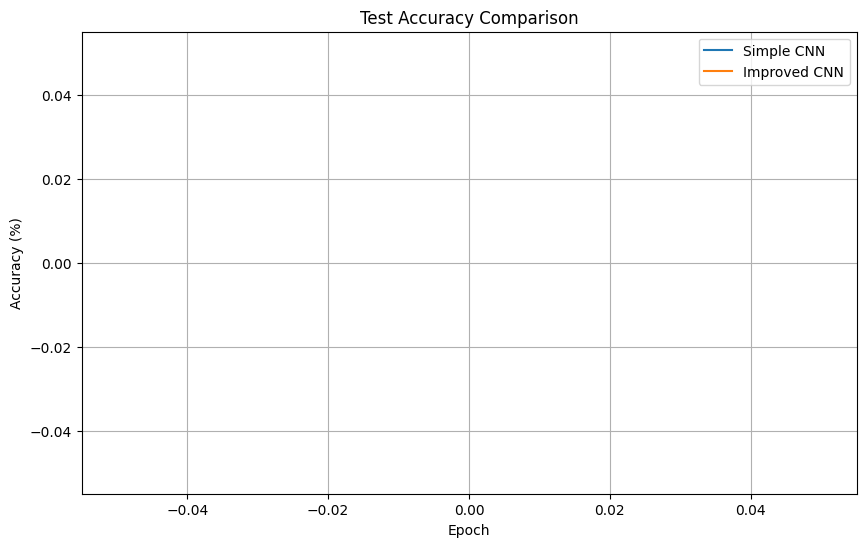

In [24]:
# Plot comparison of test accuracies
plt.figure(figsize=(10, 6))
plt.plot(test_accuracies, label='Simple CNN')
plt.plot(improved_test_accuracies, label='Improved CNN')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## 8. Scaling to CIFAR-100

Now, let's adapt our model to work with the more complex CIFAR-100 dataset, which has 100 classes instead of 10.

In [25]:
# Load CIFAR-100 dataset
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                download=True, transform=augmentation_transforms)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                               download=True, transform=transform)

cifar100_trainloader = torch.utils.data.DataLoader(cifar100_trainset, batch_size=64,
                                                 shuffle=True, num_workers=2)
cifar100_testloader = torch.utils.data.DataLoader(cifar100_testset, batch_size=64,
                                                shuffle=False, num_workers=2)

# TODO: Adapt your improved model for CIFAR-100
# You'll need to modify the final layer to output 100 classes instead of 10

# Create an instance of the model for CIFAR-100
cifar100_model = ImprovedCNN(num_classes=100).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar100_model.parameters(), lr=0.001)

# Train the model on CIFAR-100
cifar100_train_losses, cifar100_train_accuracies, cifar100_test_accuracies = train_model(
    cifar100_model, cifar100_trainloader, cifar100_testloader, criterion, optimizer, num_epochs=10)

100%|██████████| 169M/169M [00:58<00:00, 2.90MB/s] 
100%|██████████| 157/157 [00:10<00:00, 14.91it/s] 

Epoch 1/10, Train Loss: 3.7068, Test Acc: 19.26%Test Loss: 3.4443



100%|██████████| 157/157 [00:10<00:00, 14.93it/s] 

Epoch 2/10, Train Loss: 3.3372, Test Acc: 21.91%Test Loss: 3.3181



100%|██████████| 157/157 [00:10<00:00, 14.91it/s] 

Epoch 3/10, Train Loss: 3.1897, Test Acc: 23.53%Test Loss: 3.2299



100%|██████████| 157/157 [00:10<00:00, 14.92it/s] 

Epoch 4/10, Train Loss: 3.0823, Test Acc: 23.45%Test Loss: 3.2201



100%|██████████| 157/157 [00:10<00:00, 14.87it/s] 

Epoch 5/10, Train Loss: 3.0037, Test Acc: 24.53%Test Loss: 3.2241



100%|██████████| 157/157 [00:10<00:00, 14.91it/s] 

Epoch 6/10, Train Loss: 2.9361, Test Acc: 25.16%Test Loss: 3.1652



100%|██████████| 157/157 [00:10<00:00, 14.55it/s] 

Epoch 7/10, Train Loss: 2.8820, Test Acc: 24.86%Test Loss: 3.1774



100%|██████████| 157/157 [00:10<00:00, 14.83it/s] 

Epoch 8/10, Train Loss: 2.8341, Test Acc: 25.16%Test Loss: 3.1759



100%|██████████| 157/157 [00:10<00:00, 14.92it/s] 

Epoch 9/10, Train Loss: 2.7958, Test Acc: 25.87%Test Loss: 3.1651



100%|██████████| 157/157 [00:10<00:00, 14.90it/s] 

Epoch 10/10, Train Loss: 2.7601, Test Acc: 25.46%Test Loss: 3.1776


In [27]:
#num parameters in the model
torch.sum(torch.tensor([p.numel() for p in cifar100_model.parameters()]))

tensor(276780)

## 9. Final Evaluation and Comparison

Let's evaluate our models on the test sets and compare their performance:

Simple CNN on CIFAR-10: 33.28% accuracy
Improved CNN on CIFAR-10: 54.75% accuracy
Improved CNN on CIFAR-100: 25.46% accuracy


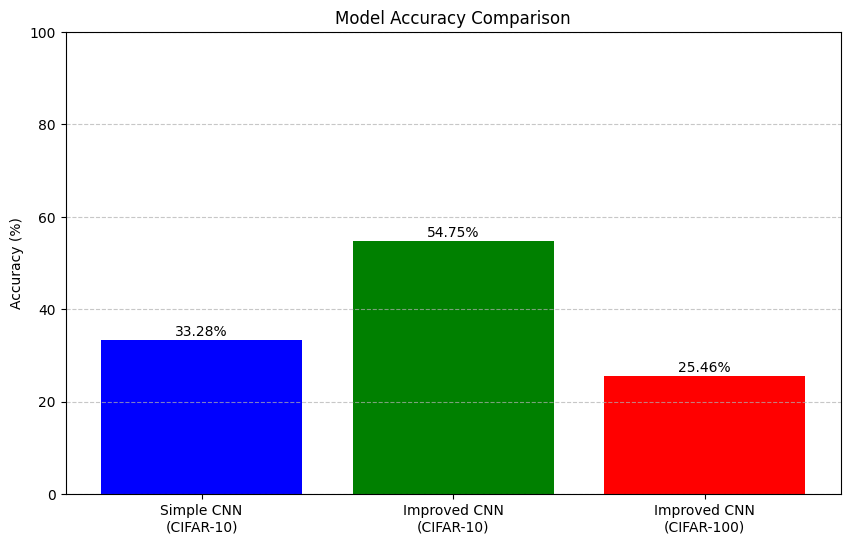

In [28]:
# Function to evaluate a model on a dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate models
simple_cifar10_accuracy = evaluate_model(model, testloader, device)
improved_cifar10_accuracy = evaluate_model(improved_model, testloader, device)
cifar100_accuracy = evaluate_model(cifar100_model, cifar100_testloader, device)

print(f"Simple CNN on CIFAR-10: {simple_cifar10_accuracy:.2f}% accuracy")
print(f"Improved CNN on CIFAR-10: {improved_cifar10_accuracy:.2f}% accuracy")
print(f"Improved CNN on CIFAR-100: {cifar100_accuracy:.2f}% accuracy")

# Plot final comparison
accuracies = [simple_cifar10_accuracy, improved_cifar10_accuracy, cifar100_accuracy]
models = ['Simple CNN\n(CIFAR-10)', 'Improved CNN\n(CIFAR-10)', 'Improved CNN\n(CIFAR-100)']

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 10. Conclusion

In this notebook, we've gone through the entire data science pipeline for image classification:

1. We loaded and explored the CIFAR-10 and CIFAR-100 datasets
2. We analyzed the datasets to understand their characteristics
3. We implemented data augmentation to improve model generalization
4. We built a simple CNN model and trained it on CIFAR-10
5. We visualized the learned filters to understand what the model is learning
6. We improved our model with additional layers and techniques
7. We adapted our model to work with the more complex CIFAR-100 dataset
8. We compared the performance of our different models

Some key takeaways:
- CNNs are powerful for image classification tasks
- Data augmentation helps improve model generalization
- Deeper models can capture more complex patterns
- As the number of classes increases (CIFAR-10 to CIFAR-100), the classification task becomes more challenging

## 11. Bonus Challenges

If you've completed the notebook and want to explore further, here are some bonus challenges:

1. Try implementing a state-of-the-art CNN architecture like ResNet or EfficientNet
2. Experiment with different learning rates and optimizers
3. Implement learning rate scheduling to improve training
4. Use transfer learning with a pre-trained model
5. Implement and compare different data augmentation techniques
6. Visualize the feature maps at different layers of your CNN
7. Implement and use techniques like Grad-CAM to visualize what your model is focusing on 